# Learning with pytorch

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Learning with pytorch

$\textbf{a)}$

In [2]:
# Define input tensors
x1 = torch.tensor([1.5], requires_grad=True)
x2 = torch.tensor([0.5], requires_grad=True)

# Compute forward traces
a = x1/x2
print('a = ',a.item())
b = -torch.exp(x2)
print('b = ',b.item())
c = torch.sin(a)
print('c = ',c.item())
d = a+b
print('d = ',d.item())
e = c+d
print('e = ',e.item())
L = d*e
print('L = ',L.item())

print('')

# Compute backward traces
grads = torch.autograd.grad(L, [x1, x2, a, b, c, d, e], retain_graph=True)
grad_x1, grad_x2, grad_a, grad_b, grad_c, grad_d, grad_e = grads
print('grad_x1 =', grad_x1.item())
print('grad_x2 =', grad_x2.item())
print('grad_a =', grad_a.item())
print('grad_b =', grad_b.item())
print('grad_c =', grad_c.item())
print('grad_d =', grad_d.item())
print('grad_e =', grad_e.item())

a =  3.0
b =  -1.6487212181091309
c =  0.14112000167369843
d =  1.3512787818908691
e =  1.492398738861084
L =  2.0166468620300293

grad_x1 = 3.01184344291687
grad_x2 = -13.723960876464844
grad_a = 1.505921721458435
grad_b = 2.843677520751953
grad_c = 1.3512787818908691
grad_d = 2.843677520751953
grad_e = 1.3512787818908691


$\textbf{b)}$

In [3]:
# Make x1 a NN parameter
x1 = torch.nn.Parameter(x1)

# Define L(x1) as a function
def L(x):
    return (torch.sin(x/x2) + x/x2 - torch.exp(x2))*(x/x2 - torch.exp(x2))

# Define the optimizer with a learning rate of 0.1
optimizer = torch.optim.Adam([x1], lr=0.1)

# Number of iterations
num_iterations = 2

# Optimization loop
for i in range(num_iterations):
    optimizer.zero_grad() # Zero the gradients 
    loss = L(x1) # Calculate the loss 
    loss.backward() # Compute gradients 
    optimizer.step() # Update x1
    
# Print the optimized value of x1
print("Optimized x1:", x1.item())

# Optimization for more epochs
num_iterations = 1000
for i in range(num_iterations):
    optimizer.zero_grad() # Zero the gradients 
    loss = L(x1) # Calculate the loss 
    loss.backward() # Compute gradients 
    optimizer.step() # Update x1
    
# Print the optimized value of x1
print("Optimized x1 after another 1000 training epochs:", x1.item())

Optimized x1: 1.2999318838119507
Optimized x1 after another 1000 training epochs: 0.6207267045974731


$\textbf{c)}$

In [4]:
# Create x1-values
x1_vals = torch.linspace(0, 2, 1000)

# Compute the derivative for each x1 value
derivatives = []
for x1_val in x1_vals:
    x1_val.requires_grad_(True)  # Set requires_grad to True for autograd
    loss = L(x1_val)
    loss.backward()
    derivatives.append(x1_val.grad.item())
    x1_val.grad.zero_()  # Clear the gradient for the next iteration

# Convert the list of derivatives to a tensor
grads = torch.tensor(derivatives)

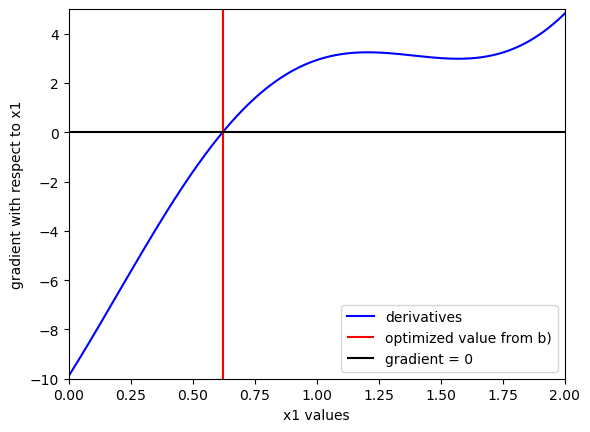

In [5]:
plt.plot(x1_vals,grads,color='blue',label='derivatives')
plt.vlines(x1.item(),ymin=-10,ymax=5,color='red',label='optimized value from b)')
plt.hlines(0,xmin=0,xmax=2,color='black',label='gradient = 0')
plt.xlabel('x1 values')
plt.ylabel('gradient with respect to x1')
plt.ylim([-10,5])
plt.xlim([0,2])
plt.legend()

We see graphically that the x1 value, where the derivative vanishes, is the same value that we obtained in b), so both results agree with eachother.

# Amplitude Regression

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


$\textbf{a)}$

In [7]:
class NpyDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.file_list = [f for f in os.listdir(data_dir) if f.endswith('.npy')]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.data_dir, self.file_list[idx])
        data = np.load(file_path).astype(np.float32)
        return {file_name: torch.from_numpy(data)}


data_directory = "tutorial-2-data"

# Erstelle eine Instanz des Datasets
dataset = NpyDataset(data_directory)

# Erstelle einen DataLoader, um bequem durch die Daten zu iterieren
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1)

# Iteriere durch den DataLoader und erstelle das Dictionary
data_dict = {}
for batch in data_loader:
    data_dict.update(batch)

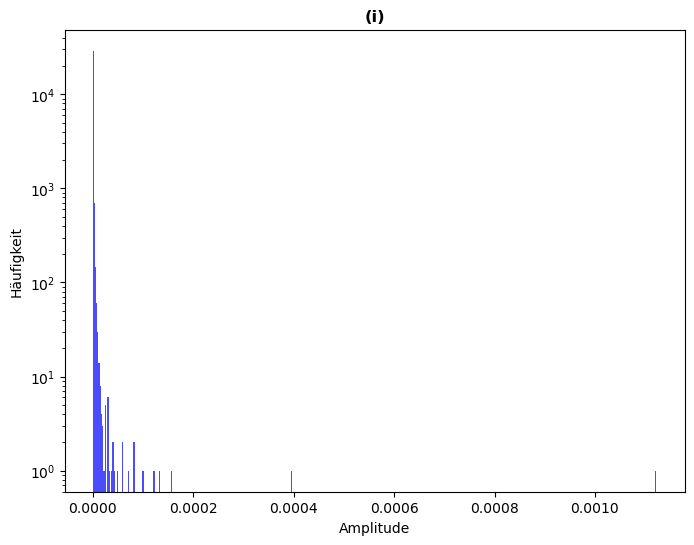

In [8]:
# Erstelle ein Histogramm
plt.figure(figsize=(8, 6))
plt.hist(data_dict['trn_amp.npy'], bins=500, color='blue', alpha=0.7)
plt.title('(i)', fontweight='bold')
plt.xlabel('Amplitude')
plt.ylabel('Häufigkeit')
plt.yscale('log')
plt.show()

In [9]:
# Extrahiere die ersten beiden Zeilen für die dritte Achse
selected_rows = data_dict['trn_dat.npy'][:, :, :2, :]

# Summiere die Einträge der zweiten Spalte der letzten Achse
sum_x = selected_rows[:, :, :, 1].sum(dim=-1)
sum_y = selected_rows[:, :, :, 2].sum(dim=-1)
sum_z = selected_rows[:, :, :, 3].sum(dim=-1)

Text(0.5, 1.0, '$p_z$')

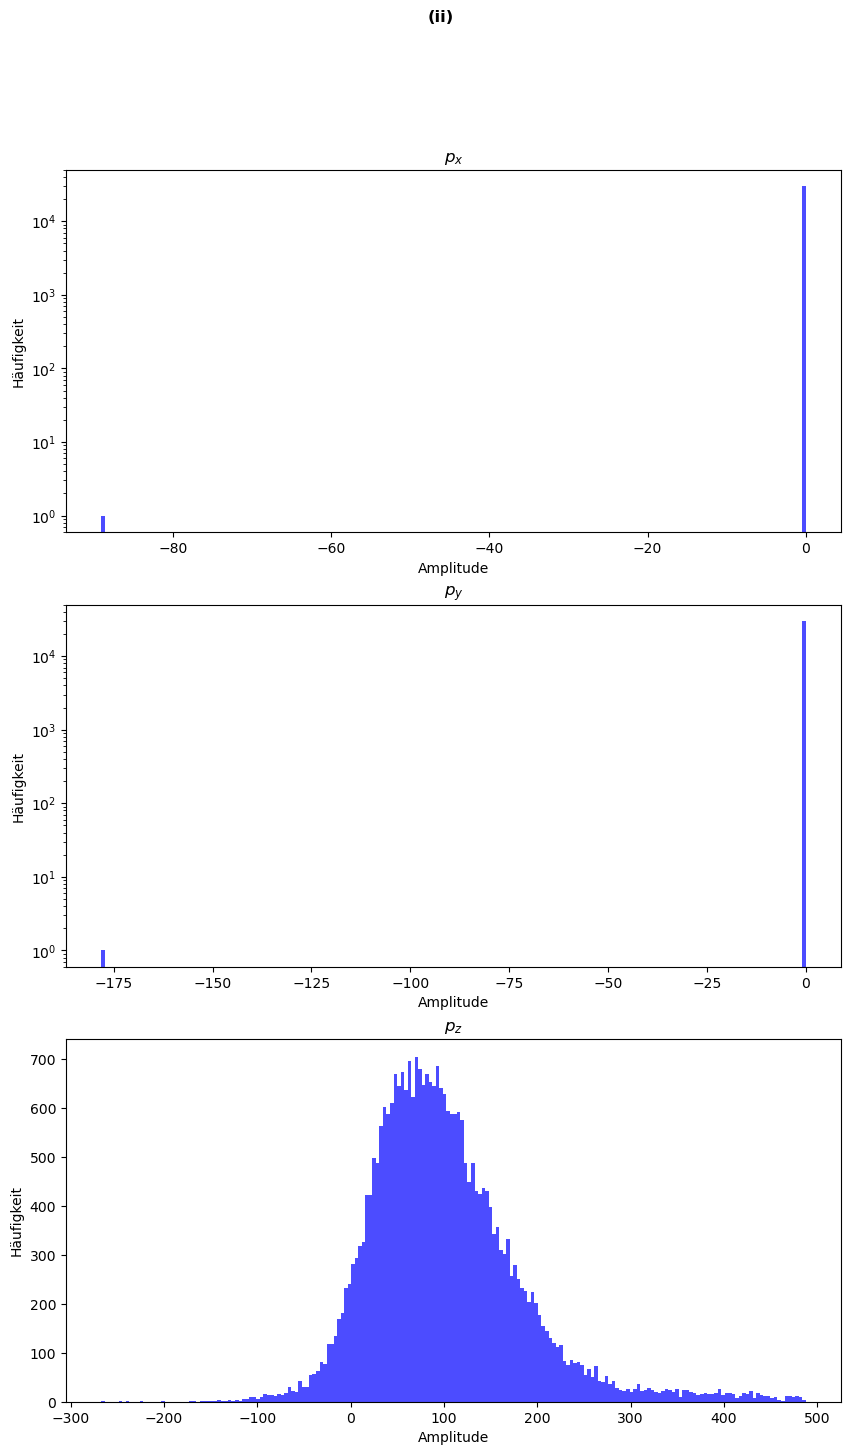

In [10]:
plt.figure(figsize=(10, 16))
plt.suptitle('(ii)', fontweight='bold')

plt.subplot(3, 1, 1)
plt.hist(sum_x, bins=200, color='blue', alpha=0.7)
plt.yscale('log')
plt.xlabel('Amplitude')
plt.ylabel('Häufigkeit')
plt.title(r'$p_x$')

plt.subplot(3, 1, 2)
plt.hist(sum_y, bins=200, color='blue', alpha=0.7)
plt.yscale('log')
plt.xlabel('Amplitude')
plt.ylabel('Häufigkeit')
plt.title(r'$p_y$')

plt.subplot(3, 1, 3)
plt.hist(sum_z, bins=200, color='blue', alpha=0.7)
plt.xlabel('Amplitude')
plt.ylabel('Häufigkeit')
plt.title(r'$p_z$')

In [11]:
# Extrahiere die ersten beiden Zeilen für die dritte Achse
gamma_1 = data_dict['trn_dat.npy'][:, :, 2:3, :]
gamma_2 = data_dict['trn_dat.npy'][:, :, 3:4, :]

# Summiere die Einträge der zweiten Spalte der letzten Achse
pt_1 = torch.sqrt((gamma_1[:, :, :, 1]**2+gamma_1[:, :, :, 2]**2).sum(dim=-1))
pt_2 = torch.sqrt((gamma_2[:, :, :, 1]**2+gamma_2[:, :, :, 2]**2).sum(dim=-1))
pt = pt_1+pt_2

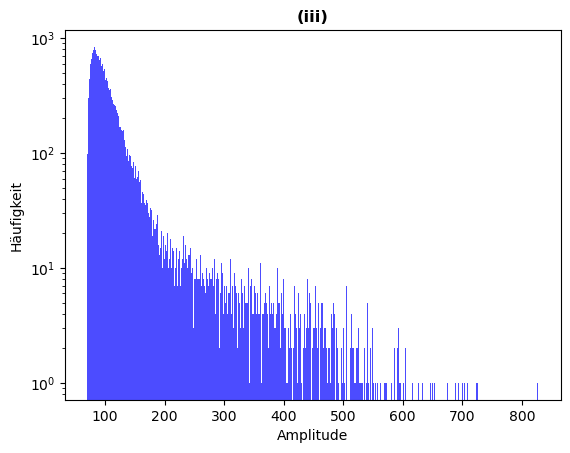

In [12]:
# Erstelle ein Histogramm
plt.hist(pt, bins=700, color='blue', alpha=0.7)
plt.title('(iii)', fontweight='bold')
plt.xlabel('Amplitude')
plt.ylabel('Häufigkeit')
plt.yscale('log')
plt.show()

In [13]:
# Extrahiere die ersten beiden Zeilen für die dritte Achse
gin_1 = data_dict['trn_dat.npy'][:, :, 0:1, :]
gin_2 = data_dict['trn_dat.npy'][:, :, 1:2, :] 
gamma_1 = data_dict['trn_dat.npy'][:, :, 2:3, :]
gamma_2 = data_dict['trn_dat.npy'][:, :, 3:4, :]
gout_3 = data_dict['trn_dat.npy'][:, :, 4:5, :]


# Summiere die Einträge der zweiten Spalte der letzten Achse
pt_1 = torch.sqrt((gin_1[:, :, :, 1]**2+gin_1[:, :, :, 2]**2).sum(dim=-1))
pt_2 = torch.sqrt((gin_2[:, :, :, 1]**2+gin_2[:, :, :, 2]**2).sum(dim=-1))
pt_3 = torch.sqrt((gamma_1[:, :, :, 1]**2+gamma_1[:, :, :, 2]**2).sum(dim=-1))
pt_4 = torch.sqrt((gamma_2[:, :, :, 1]**2+gamma_2[:, :, :, 2]**2).sum(dim=-1))
pt_5 = torch.sqrt((gout_3[:, :, :, 1]**2+gout_3[:, :, :, 2]**2).sum(dim=-1))

miss_pt = -(-pt_1-pt_2+pt_3+pt_4+pt_5)

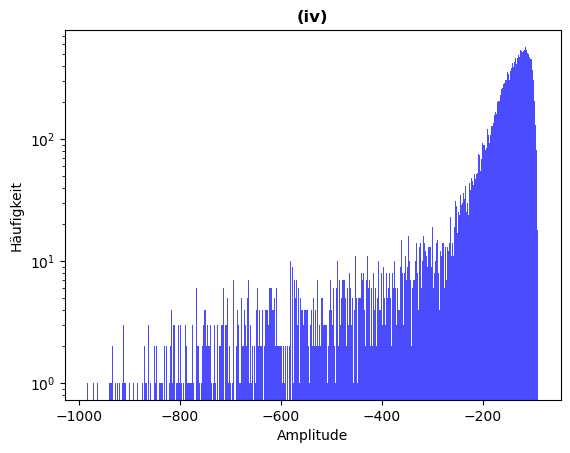

In [14]:
# Erstelle ein Histogramm
plt.hist(miss_pt, bins=700, color='blue', alpha=0.7)
plt.title('(iv)', fontweight='bold')
plt.xlabel('Amplitude')
plt.ylabel('Häufigkeit')
plt.yscale('log')
plt.show()

$\textbf{b)}$

Our training data set contains 30000 events, where 5 particles are envolved in each event and we have 4 numbers (4-momentum vector) given per particle. As an input to our network we need the momenta of all 5 particles as a one dimensional tensor for each event seperatly.

Since we have 30000 events we use a batch size of 60 instead of 64 so that we can split our data into equally large batches.

In [15]:
# transforming our input data into the desired shapes
training_data = data_dict['trn_dat.npy'].reshape(1, 30000, -1).squeeze()
trn_target = data_dict['trn_amp.npy'].squeeze().unsqueeze(1)
validation_data = data_dict['val_dat.npy'].reshape(1, 30000, -1).squeeze()
val_target = data_dict['val_amp.npy'].squeeze().unsqueeze(1)
test_data = data_dict['tst_dat.npy'].reshape(1, 30000, -1).squeeze()
tst_target = data_dict['tst_amp.npy'].squeeze().unsqueeze(1)

In [16]:
class CustomDataset(Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data
        self.length = len(input_data)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        input_sample = self.input_data[idx]
        target_sample = self.target_data[idx]
        return {'input': input_sample, 'target': target_sample}
    
trn_dataset = CustomDataset(training_data, trn_target)
val_dataset = CustomDataset(validation_data, val_target)
tst_dataset = CustomDataset(test_data, tst_target)

batch_size = 60
trn_data_loader = DataLoader(dataset=trn_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
tst_data_loader = DataLoader(dataset=tst_dataset, batch_size=batch_size, shuffle=True)

$\textbf{c)}$

In [17]:
# Define the neural network model
class RegressionNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Instantiate the model
input_size = 20
hidden_size = 32
output_size = 1
model = RegressionNet(input_size, hidden_size, output_size)

# Define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
# Training loop
num_epochs = 10000
trn_inp, trn_tar = next(iter(trn_data_loader)).values()
val_inp, val_tar = next(iter(val_data_loader)).values()
tst_inp, tst_tar = next(iter(tst_data_loader)).values()

val_loss = []


for epoch in range(num_epochs):
    
    model.train()
    # Forward pass
    predictions = model(trn_inp)
    # Compute the loss
    loss = loss_fn(predictions, trn_tar)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()  # Setze das Modell in den Evaluationsmodus
    with torch.no_grad():  # Deaktiviere die Berechnung von Gradienten für die Validierung
        # Forward pass
        val_predictions = model(val_inp)
        # Compute the validation loss
        val_loss.append(loss_fn(val_predictions, val_tar))

# Test
model.eval()  # Setze das Modell in den Evaluationsmodus
with torch.no_grad():  # Deaktiviere die Berechnung von Gradienten für den Test
    # Forward pass
    tst_predictions = model(tst_inp)
    # Compute the test loss
    tst_loss = loss_fn(tst_predictions, tst_tar)

Text(0.5, 1.0, 'training on single batch')

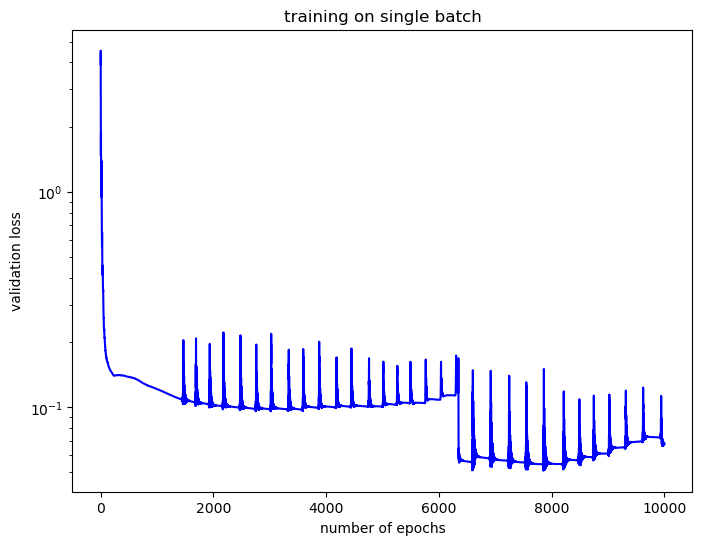

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(num_epochs),val_loss,color='blue')
plt.xlabel('number of epochs')
plt.ylabel('validation loss')
plt.yscale('log')
plt.title('training on single batch')

In [20]:
print('After training the NN on one batch, the loss for the first test batch is: ',tst_loss.item())

After training the NN on one batch, the loss for the first test batch is:  0.06161238253116608


$\textbf{d)}$

In [21]:
model2 = RegressionNet(input_size, hidden_size, output_size)
num_epochs = 10000

# Define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

val_loss = np.zeros(num_epochs)

for epoch in tqdm(range(num_epochs)):

    validation_loss = np.zeros(len(val_data_loader))

    model2.train()
    for batch in trn_data_loader:
        trn_inputs, trn_targets = batch['input'], batch['target']
        # Forward pass
        predictions = model2(trn_inputs)
        # Compute the loss
        loss = loss_fn(predictions, trn_targets)

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    # Validation
    model2.eval()  # Setze das Modell in den Evaluationsmodus
    with torch.no_grad():  # Deaktiviere die Berechnung von Gradienten für die Validierung
        for i, batch in enumerate(val_data_loader):
            val_inputs, val_targets = batch['input'], batch['target']
            # Forward pass
            val_predictions = model2(val_inputs)
            # Compute the validation loss
            validation_loss[i] = loss_fn(val_predictions, val_targets).item()

    val_loss[epoch] = np.mean(validation_loss)
        
# Test
test_loss = np.zeros(len(tst_data_loader))

model2.eval()  # Setze das Modell in den Evaluationsmodus
with torch.no_grad():  # Deaktiviere die Berechnung von Gradienten für den Test
    for i, batch in enumerate(tst_data_loader):
        tst_inputs, tst_targets = batch['input'], batch['target']   
        # Forward pass
        tst_predictions = model2(tst_inputs)
        # Compute the test loss
        test_loss[i] = loss_fn(tst_predictions, tst_targets)
        
tst_loss = np.mean(test_loss)

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'training on whole dataset')

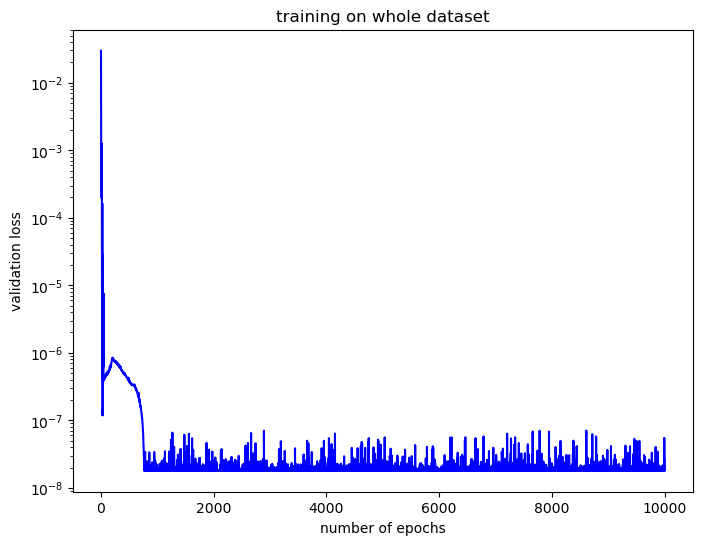

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(num_epochs),val_loss,color='blue')
plt.xlabel('number of epochs')
plt.ylabel('validation loss')
plt.yscale('log')
plt.title('training on whole dataset')

In [23]:
print('After training the NN on one batch, the loss for the test dataset: ',tst_loss.item())

After training the NN on one batch, the loss for the test dataset:  4.58229995103504e-08


In [24]:
for key in data_dict:
    print(key)

val_amp.npy
training_data.npy
tst_amp.npy
test_amp.npy
val_dat.npy
tst_dat.npy
test_data.npy
trn_amp.npy
training_amp.npy
trn_dat.npy


In [25]:
data_dict['trn_amp.npy'].shape

torch.Size([1, 30000])

In [26]:
data_dict['training_amp.npy'].shape

torch.Size([1, 32751])

In [27]:
data_dict['trn_dat.npy'].shape

torch.Size([1, 30000, 5, 4])

In [28]:
data_dict['training_data.npy'].shape

torch.Size([1, 32751, 5, 4])

In [29]:
data_dict['val_amp.npy'].shape

torch.Size([1, 30000])

In [30]:
data_dict['val_dat.npy'].shape

torch.Size([1, 30000, 5, 4])

In [31]:
data_dict['tst_amp.npy'].shape

torch.Size([1, 30000])

In [32]:
data_dict['test_amp.npy'].shape

torch.Size([1, 326465])

In [33]:
data_dict['tst_dat.npy'].shape

torch.Size([1, 30000, 5, 4])

In [34]:
data_dict['test_data.npy'].shape

torch.Size([1, 326465, 5, 4])